In [1]:
import numpy as np
from scipy.io import loadmat
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

In [2]:
input_layer_size  = 400 # % 20x20 Input Images of Digits
hidden_layer_size = 25 #   % 25 hidden units
num_labels = 10

In [4]:
data = loadmat('ex4data1', mat_dtype=True)
X_orig = data['X']
m = X_orig.shape[0]
X = ((X_orig-X_orig[:].min(axis = 1).reshape(m,1))/(X_orig[:].max(axis = 1)-X_orig[:].min(axis = 1)).reshape(m,1)*255).astype(int)
y = data['y']


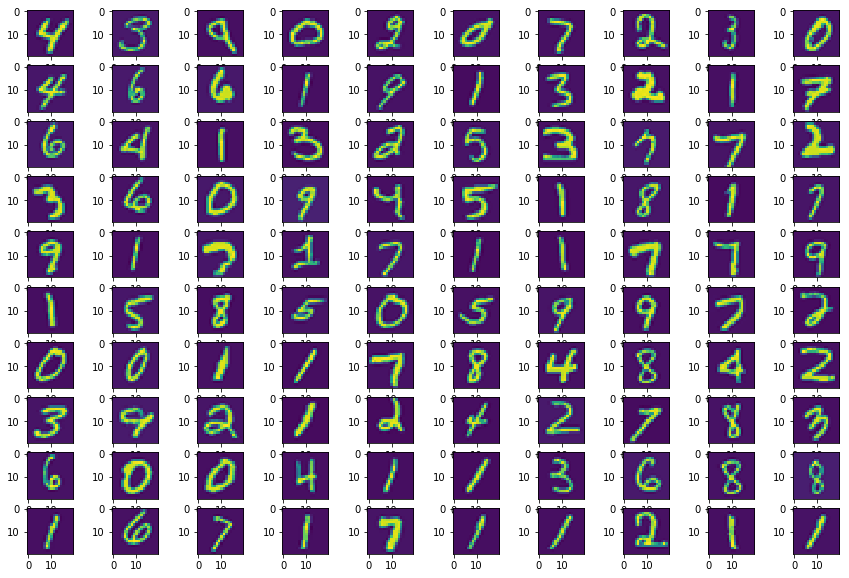

In [6]:
indicies = np.random.choice(np.arange(m), 100)

cols,rows=10,10
fig, ax  = plt.subplots(rows,cols, figsize=[15,10])
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(scipy.misc.toimage(X[indicies[i*cols+j]].reshape(20,20).T))
plt.show()

In [7]:
weights_file = loadmat('ex4weights.mat', mat_dtype=True)

In [8]:
Theta1_orig, Theta2_orig = weights_file['Theta1'], weights_file['Theta2']

In [37]:
def sigmoid(x, theta):
    return 1/(1+np.e**-x.dot(theta))

In [63]:
def sigmoidZ(z):
    return 1/(1+np.e**-z)

In [64]:
def gradSigmoid(z):
    return sigmoidZ(z)*(1-sigmoidZ(z))

In [67]:
def epsilonOpt(L1,L2):
    return np.sqrt(6)/np.sqrt(L1+L2)

In [87]:
def randThetaInit(no_in, no_un, epsilon):
    return epsilon*(2*np.random.random((no_un, no_in))-1)

In [96]:
Theta1_init = randThetaInit(401,25,.12)
Theta2_init = randThetaInit(26,10,.12)

In [12]:
def perdict(X, theta1, theta2):
    IL = np.insert(X, 0, 1, axis=1)
    HL = sigmoid(IL, theta1.T)
    HL = np.insert(HL, 0, 1, axis=1)
    OL = sigmoid(HL, theta2.T)
    return (np.argmax((OL), axis=1) + 1).reshape(OL.shape[0],1)

In [48]:
p = perdict(X_orig, Theta1_orig, Theta2_orig)

In [49]:
np.mean(p==y)

0.97519999999999996

In [15]:
encoder = OneHotEncoder()

In [16]:
y_oh = encoder.fit_transform(y).toarray()

In [19]:
def ff_nn(X, theta1, theta2):
    X_bias = np.insert(X,0,1,axis=1) #np.append(1,X, axis=1) #add axis condition
    IL = sigmoid(X_bias, theta1.T)
    IL = np.insert(IL,0,1,axis=1) # np.append(1, IL, axis=1)   #add axis condition
    OL = sigmoid(IL, theta2.T)
    return OL

In [104]:
def ff_nn_one_exmpl(X, theta1, theta2):
    X_bias = np.insert(X,0,1,axis=0) #np.append(1,X, axis=1) #add axis condition
    IL = sigmoid(X_bias, theta1.T)
    IL = np.insert(IL,0,1,axis=0) # np.append(1, IL, axis=1)   #add axis condition
    OL = sigmoid(IL, theta2.T)
    return OL

In [41]:
ff_res = ff_nn(X_orig, Theta1_orig, Theta2_orig)

In [61]:
def costFunc(X,y,theta1,theta2,lmbd):
    predicted = ff_nn(X, theta1, theta2)
    part1 = -y*np.log(predicted)
#     print(part1)
    part2 = -(1-y)*np.log(1e-300+1-predicted)
#     print(part2)
    part3 = ((theta1[:,1:]**2).sum() + (theta2[:,1:]**2).sum())/2
    print(((part1+part2).sum() + part3)/m)

In [62]:
costFunc(X_orig, y_oh, Theta1_orig, Theta2_orig, 1)

0.383769859091


In [119]:
def backProp(X, y, ff_func, theta1, theta2, lmbd):
    m = X.shape[0]
    m=1
    for t in range(m):
        ff_res = ff_func(X[t], theta1, theta2)
        print(ff_res-y[t])

In [120]:
backProp(X_orig, y_oh, ff_nn_one_exmpl, Theta1_orig, Theta2_orig, 1)

[  1.12661530e-04   1.74127856e-03   2.52696959e-03   1.84032321e-05
   9.36263860e-03   3.99270267e-03   5.51517524e-03   4.01468105e-04
   6.48072305e-03  -4.26598801e-03]
